<a href="https://colab.research.google.com/github/WestChaeVI/Data-Network-Analysis/blob/main/Task/CV_seminar_week_7(testing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':""
torch.cuda.manual_seed_all(42)
device

'cuda'

In [3]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


# 학습한 model 불러오기

In [6]:
state_dict = torch.load('resnet50_56_91.929.pth')

best_epoch = state_dict['epoch'] # 38
best_test_acc = state_dict['test_acc']
weights = state_dict['net'] # best epoch에서의 가중치

print(f'{best_epoch}번째 epoch에서 valid셋 기준으로 {best_test_acc}% 를 달성하였습니다.')

56번째 epoch에서 valid셋 기준으로 91.929% 를 달성하였습니다.


# 학습한 가중치를 모델에 적용하기

In [7]:
from torchvision import models # model 라이브러리
import torch.nn as nn


weights_path = '/content/drive/MyDrive/CV_seminar_project/resnet50_56_91.929.pth'
weights = torch.load(weights_path)
resnet_50 = models.resnet50(pretrained = False).to(device)

# fine tuning
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)
resnet_50.load_state_dict(weights['net'])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

# 데이터셋 불러오기

In [9]:
from cv_dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224), # 
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2() # 텐서화만 적용 , pytorch albumentation의 totensor 는 min_max scaling 적용까지
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# testset의 최종 성능 확인하기 (90.77%)
과제
> 모델은 100epochs를 돌려서 만든 가중치를 이용한다.   
> test_loader를 생성하여, test셋의 최종 성능을 평가한다.   

In [8]:
import torch.nn as nn

# 하이퍼파라미터
batch_size = 8
lr = 0.0001
epochs = 100
optimizer_name = 'adam'

model_name = 'resnet50'
criterion = nn.CrossEntropyLoss().to(device) # cost function 패널티 주는 역할

root_path = '/content/drive/MyDrive/CV_seminar_project'
train_path = '/content/drive/MyDrive/CV_seminar_project/train'
valid_path = '/content/drive/MyDrive/CV_seminar_project/valid'

In [10]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8) # 학습을 할수록 학습률 낮춰주는 역할(러닝 보폭 줄이기, 섬세하게 보기위해)

In [11]:
from tqdm import tqdm
import argparse
import logging
from pathlib import Path
from torch import optim
import numpy as np

train_acc_lst, train_loss_lst, test_acc_lst, test_loss_lst= [], [], [], []

epochs = 30
model_name = 'resnet50'
state={}

for epoch in range(1, epochs+1):

  train_loss = 0.0
  total = 0
  correct = 0
  train_acc = 0
  
  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)

    output = resnet_50(train_img) # 모델에 입력

    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화    
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    train_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1)
   
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct / total)

  train_loss = round(train_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(train_loss)

  # -------------------------------------------------------------------------------------
  test_loss = 0.0
  corrects = 0
  totals = 0
  test_acc = 0

  resnet_50.eval()
  with torch.no_grad():

    for i, (test_img, test_label) in enumerate(test_loader):
          # gpu에 할당
      test_img = test_img.to(device)
      test_label = test_label.to(device)

      outputs = resnet_50(test_img) # 모델에 입력
      losses = criterion(outputs, test_label)

      # loss & acc
      test_loss += losses.item()
      _, predictions = torch.max(outputs.data ,dim = 1 )
    
      totals += test_label.size(0)
      corrects += (predictions == test_label).sum().item()
      test_acc += 100 * (corrects / totals)

    test_loss = round(test_loss/(i+1), 3) # 소수점 반올림
    test_acc = round(test_acc/(i+1), 3)
    print(f'Testset {epoch}/{epochs} Loss : {test_loss}, Accuracy : {test_acc}% \n')
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
  
  # 모델 저장
  if np.max(test_acc_lst) <= test_acc:

    state['epoch'] = epoch
    state['net'] = resnet_50.state_dict()

    state['train_loss'] = train_loss
    state['test_loss'] = test_loss

    state['train_acc'] = train_acc
    state['test_acc'] = test_acc
torch.save(state, '/content/drive/MyDrive/CV_seminar_project/test_resnet50_{}_{}.pth'.format(str(state['epoch']), str(state['test_acc'])))

Trainset 1/30 Loss : 0.096, Accuracy : 97.299%
Testset 1/30 Loss : 0.425, Accuracy : 84.4% 

Trainset 2/30 Loss : 0.058, Accuracy : 98.775%
Testset 2/30 Loss : 0.419, Accuracy : 80.86% 

Trainset 3/30 Loss : 0.083, Accuracy : 97.607%
Testset 3/30 Loss : 0.399, Accuracy : 87.073% 

Trainset 4/30 Loss : 0.12, Accuracy : 97.002%
Testset 4/30 Loss : 0.452, Accuracy : 83.224% 

Trainset 5/30 Loss : 0.061, Accuracy : 98.086%
Testset 5/30 Loss : 0.442, Accuracy : 82.243% 

Trainset 6/30 Loss : 0.143, Accuracy : 96.887%
Testset 6/30 Loss : 0.461, Accuracy : 81.555% 

Trainset 7/30 Loss : 0.139, Accuracy : 94.49%
Testset 7/30 Loss : 0.328, Accuracy : 80.491% 

Trainset 8/30 Loss : 0.108, Accuracy : 96.221%
Testset 8/30 Loss : 0.301, Accuracy : 81.315% 

Trainset 9/30 Loss : 0.073, Accuracy : 97.27%
Testset 9/30 Loss : 0.341, Accuracy : 89.238% 

Trainset 10/30 Loss : 0.074, Accuracy : 97.981%
Testset 10/30 Loss : 0.441, Accuracy : 79.888% 

Trainset 11/30 Loss : 0.07, Accuracy : 97.971%
Testset

In [12]:
state['epoch'], state['test_acc']

(15, 90.769)

Text(0.5, 1.0, 'loss')

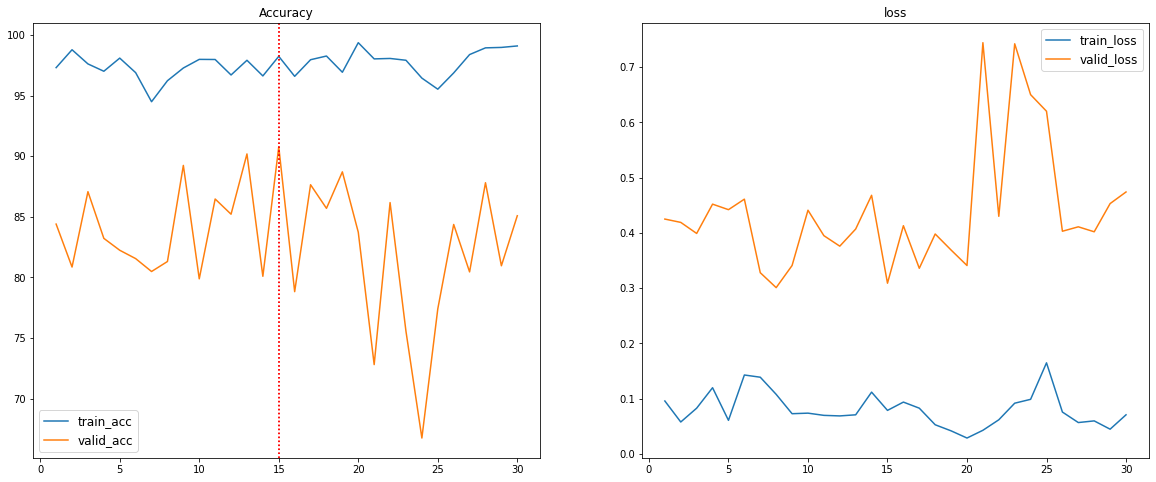

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots( nrows = 1, ncols = 2, figsize = (20, 8) )
 
axes[0].plot(np.arange(1,len(train_acc_lst)+1), train_acc_lst, label = 'train_acc')
axes[0].plot(np.arange(1,len(test_acc_lst)+1), test_acc_lst, label = 'valid_acc')
axes[0].axvline(x=state['epoch'], ymin=0, ymax=100, color='r', linestyle=':')
axes[0].legend(fontsize=12)
axes[0].set_title('Accuracy')

axes[1].plot(np.arange(1,len(train_loss_lst)+1), train_loss_lst, label = 'train_loss')
axes[1].plot(np.arange(1,len(test_loss_lst)+1), test_loss_lst, label = 'valid_loss')
axes[1].axvline(x=state['epoch'], ymin=0, ymax=100, color='r', linestyle=':')
axes[1].legend(fontsize=12)
axes[1].set_title('loss')

In [22]:
print('{}번째 epoch에서 test셋 기준으로 {}% 를 달성하였습니다.'.format(str(state['epoch']), str(state['test_acc'])))

15번째 epoch에서 test셋 기준으로 90.769% 를 달성하였습니다.
